# Download Weather Data from Meteostat

Meteostat has one of the biggest databanks for weather data worldwide. For Germany it uses all stations from the Deutsche Wetter Dienst and further public weather stations. Meteostat provides two ways to download the data, using the API and a Python library.

Since the number of API calls allowed per day (2000) is not enough for the scope of this project, it is better to use the Python library, which was released Oct. 2020. However, for quality control, random samples will be compare to the data provided by the API

Please notice: **To use the API a security key is needed**. Please refer to the documentation to obtain one 

The documentation can be found [here](https://dev.meteostat.net/python/hourly.html#aggregation)

In [1]:
# Import Meteostat library to download the hourly data and API calls
from meteostat import Stations, Hourly
from security_key import security_key
from datetime import datetime
import requests

# Import all other libraries
import pandas as pd
import time
import os
from functools import reduce

# Import libraries to plot the weather stations geographical locations
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

## Weather Stations in Germany

Get a list of all the weather stations in Germany. It is also possible to change the country and get all the information for that country. Please refer to the documentation for the right coding of the country

In [2]:
stations = Stations(country = 'DE')
all_stationsDE = stations.fetch(0)
all_stationsDE.head(10)

,id,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end
1248,10004,UFS TW Ems,DE,HH,10004.0,None,54.1667,6.3500,0.0,Europe/Berlin,2018-01-27,2020-11-17,2000-07-01,2020-11-05
1249,10007,UFS Deutsche Bucht.,DE,HH,10007.0,None,54.1833,7.4333,0.0,Europe/Berlin,2018-01-27,2020-11-17,1998-01-01,2020-11-03
1250,10008,Nordseeboje 2,DE,HH,10008.0,None,55.0000,6.3333,3.0,Europe/Berlin,NaT,NaT,2008-09-28,2008-12-30
1251,10015,Helgoland,DE,SH,10015.0,EDXH,54.1833,7.9000,4.0,Europe/Berlin,1951-01-01,2020-11-17,1952-05-01,2020-11-05
1252,10018,Westerland / Sylt,DE,SH,10018.0,EDXW,54.9167,8.3500,16.0,Europe/Berlin,1989-03-18,2020-11-17,NaT,NaT
1253,10020,List / Sylt,DE,SH,10020.0,None,55.0167,8.4167,26.0,Europe/Berlin,1949-01-01,2020-11-17,1931-01-01,2020-11-05
1254,10022,Leck,DE,SH,10022.0,EDNL,54.8000,8.9500,7.0,Europe/Berlin,1974-11-01,2020-11-17,1973-01-01,2020-11-05
1255,10026,Husum,DE,SH,10026.0,None,54.5167,9.1500,28.0,Europe/Berlin,2018-01-28,2020-11-17,1891-01-01,1974-06-30
1256,10028,St Peter Ording / St. Peter-ording / Bad Sank...,DE,SH,10028.0,EDXO,54.3297,8.6028,5.0,Europe/Berlin,1951-01-01,2020-11-17,1951-01-01,2020-11-05
1257,10033,Gluecksburg / Meierwik,DE,SH,10033.0,ETGG,54.8333,9.5000,27.0,Europe/Berlin,1973-01-03,2020-11-17,2015-09-05,2018-12-27


In [3]:
all_stationsDE.shape

(1128, 14)

In [4]:
# create a list with all the stations in Germany
stations_list = list(all_stationsDE.id)
len(stations_list)

1128

(1128, 9)
(1127, 9)


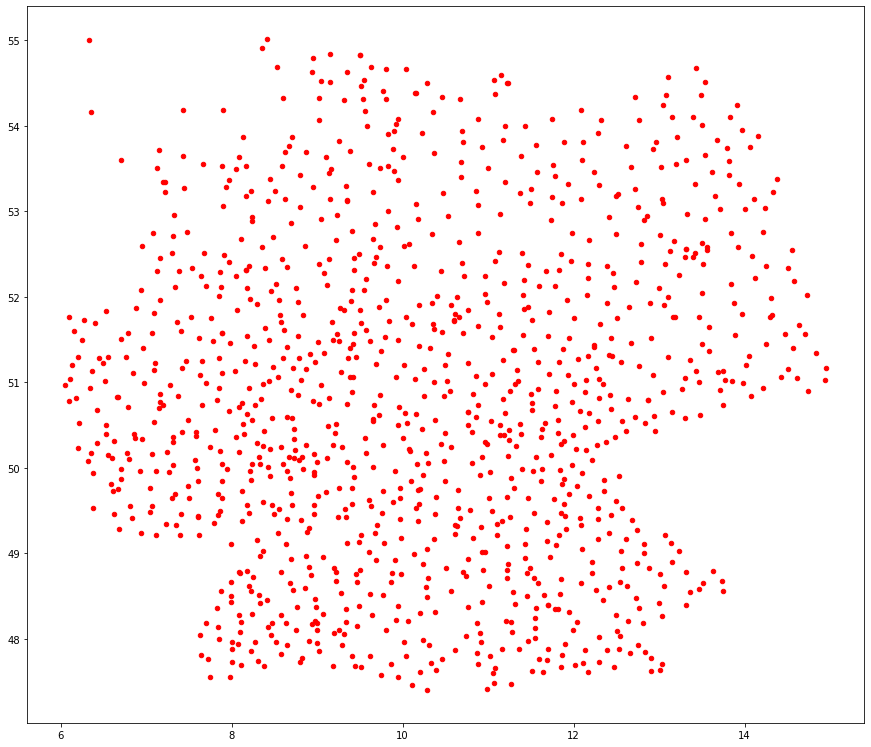

In [5]:
# Get a view of the geographical location of each weather station in GERMANY
# Change the code for a different country!
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(all_stationsDE, 
                          geometry = gpd.points_from_xy(all_stationsDE.longitude, 
                                                        all_stationsDE.latitude))
geo_df.drop(columns=['wmo', 
                     'icao', 
                     'elevation', 
                     'timezone', 
                     'hourly_start', 
                     'hourly_end'], inplace=True)

# Get rid of wrong labeled stations
print(geo_df.shape)
geo_df_2 = geo_df.drop(geo_df.query('latitude < 40').index)
print(geo_df_2.shape)

# create the plot
fig, ax = plt.subplots(figsize=(15,15))
geo_df_2.plot(ax=ax, markersize=20, color='red', marker = 'o')

## Download the Data from each Weather Station

After some trial and error, the python library do not fetch all the data for a long period in time. To avoid this problem, data for each year will be downloaded separately and then merged together.

In [29]:
# Define the time horizon to download the data
# Time-format: Year, Month, Day, Hour, Minute

# Number of years to download
num_of_years_to_download = 7
# last day of the data
most_recent_date = '202010252359'

most_recent_year = int(most_recent_date[:4])
most_recent_month = int(most_recent_date[4:6])
most_recent_day = int(most_recent_date[6:8])
most_recent_hour = int(most_recent_date[-4:-2])
most_recent_minute = int(most_recent_date[-2:])

In [30]:
# create a new folder to store the csv files:
folder_name = 'data_weather'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [31]:
# Download weather data from all stations for each year

# create a dictionary to save all missing years for each weather station
missing_values_dict = dict()
missing_values_dict['Empty_dfs'] = list()
for station in stations_list:
    missing_values_dict[station] = list()

# loop over each year
for year in range(num_of_years_to_download):
    time.sleep(20) # wait 20 secs before loading the next year
    
    # loop over each weather station
    list_of_dfs = []
    for station in stations_list:
        time.sleep(1) # wait 1 sec before loading the next weather station
        try:
            # Fetch hourly data for each station for each year
            data = Hourly([station], start = datetime(most_recent_year-year-1, 10, 26), end = datetime(most_recent_year-year, 10, 26, 23, 59))
            # create dataframe
            df = data.fetch()
            df.drop(columns=['station'], inplace=True)
            name_of_columns = df.columns
            new_names = df.columns[:1].append(station + '_' + df.columns[1:])
            df.columns = new_names
            df.dropna(axis=0, how='all', inplace=True)
            df.dropna(axis=1, how='all', inplace=True)
            list_of_dfs.append(df)
        except:
            print(f'No data available station id {station} in the year {2020-year}')
            missing_values_dict[station].append(year) 
    
    # merge all the data and save it locally
    print(f'-------------------\n starting merging of year {2020-year}\n-------------------')
    
    non_empty_dfs = [dataframe for dataframe in list_of_dfs if dataframe.empty != True]
    df_merged = non_empty_dfs[0]
    for dataframe in non_empty_dfs[1:]:
        df_merged = df_merged.merge(dataframe, on='time', how='outer')
    
    df_merged.dropna(axis=0, how='all', inplace=True)
    df_merged.dropna(axis=1, how='all', inplace=True)
    df_merged.to_csv(folder_name + '/' + f'{2020-year}_all_stations.csv', index=False)

No data available station id 10008 in the year 2020
No data available station id 10043 in the year 2020
No data available station id 10067 in the year 2020
No data available station id 10127 in the year 2020
No data available station id 10486 in the year 2020
No data available station id D0096 in the year 2020
No data available station id D0510 in the year 2020
No data available station id D0645 in the year 2020
No data available station id D0807 in the year 2020
No data available station id D1093 in the year 2020
No data available station id D1426 in the year 2020
No data available station id D1666 in the year 2020
No data available station id D2315 in the year 2020
No data available station id D2349 in the year 2020
No data available station id D2409 in the year 2020
No data available station id D2475 in the year 2020
No data available station id D2677 in the year 2020
No data available station id D3623 in the year 2020
No data available station id D5688 in the year 2020
No data avai

## Quality Control Using the API Call

In [34]:
url = "https://api.meteostat.net/v2/stations/hourly?station=D0400&start=2020-01-01&end=2020-01-02"
headers = {'x-api-key': security_key}

response = requests.post(url, headers=headers)
data = response.json()
data

{'meta': {'source': 'National Oceanic and Atmospheric Administration, Deutscher Wetterdienst',
  'exec_time': 0.093,
  'generated': '2020-11-13 16:31:36'},
 'data': [{'time': '2020-01-01 00:00:00',
   'temp': 4,
   'dwpt': 1.4,
   'rhum': 83,
   'prcp': 0,
   'snow': None,
   'wdir': None,
   'wspd': None,
   'wpgt': None,
   'pres': None,
   'tsun': None,
   'coco': None},
  {'time': '2020-01-01 01:00:00',
   'temp': 2.9,
   'dwpt': 1.4,
   'rhum': 90,
   'prcp': 0,
   'snow': None,
   'wdir': None,
   'wspd': None,
   'wpgt': None,
   'pres': None,
   'tsun': None,
   'coco': None},
  {'time': '2020-01-01 02:00:00',
   'temp': 2,
   'dwpt': 1.1,
   'rhum': 94,
   'prcp': 0,
   'snow': None,
   'wdir': None,
   'wspd': None,
   'wpgt': None,
   'pres': None,
   'tsun': None,
   'coco': None},
  {'time': '2020-01-01 03:00:00',
   'temp': 2,
   'dwpt': 1.4,
   'rhum': 96,
   'prcp': 0,
   'snow': None,
   'wdir': None,
   'wspd': None,
   'wpgt': None,
   'pres': None,
   'tsun': None,


## Join Weather Data in One Big Dataframe

In [66]:
# create the list of files to create the df and concatenate them
files_list = [file for file in os.listdir(folder_name) if file[-4:] == '.csv']
files_list.sort()

In [67]:
# read each file as DataFrame and concatenate
df = pd.read_csv(folder_name + '/' + files_list[0])
for dataframe in files_list[1:]:
    df_to_concat = pd.read_csv(folder_name + '/' + dataframe)
    df = pd.concat([df, df_to_concat], ignore_index=True)

/Users/juangarcia/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1878,1893,1934,2140,2150,2158,2207,2449,2462,2501,2645,2783,2830,2858,3279,3327,3373,3600,3675,3714,3756,4211,4231,4284,4365,4397) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/juangarcia/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1918,1920,1965,2111,2140,2144,2187,2270,2307,2309,2349,2409,2419,2537,2824,2952,2995,3017,3083,3123,3152,3233,3275,3362,3397,3603,3650,3667,3814,3844,3945,3971,4081,4083,4223,4251,4359,4391,4402,4428,4434) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/juangarcia/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1981,2049,2118,2211

In [68]:
print(f'The number of duplicates in the dataframe is {df.duplicated().sum()}\n')
df.drop_duplicates(inplace=True)
print(f'The shape of the dataframe is {df.shape}')

The number of duplicates in the dataframe is 144

The shape of the dataframe is (61392, 5992)


In [69]:
# save the new file locally for easy access
df.to_csv(folder_name + '/' + 'weather_data_since_2013.csv')